# RAG Agent

Come vedimao il workflow diventa un po' più complesso.
In questo caso, vogliamo usare un classificatore che decide se una question è sul topic o è off topic.

Se la question è sul topic, l'agente procede a recuperare i documenti rilevanti e generare una risposta. Tuttavia, se la question è off topic, restituisce una risopsta di off_topic senza fare il retrieve dei documenti.

Questo design assicura che il sistema processi solo le queries più rilevanti.

Implementiamo questo step by step.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain import hub

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

# Create a vectorstore from the documents
db = Chroma.from_documents(docs, embedding_function)

# Dopo aver creato il vectorstore, lo convertiamo in un retriever
retriever = db.as_retriever(search_kwargs={"k": 4})

In [3]:
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm

c:\Users\felip\Desktop\LangGraph_Advanced\LangGraph-mio\.venv\lib\site-packages\langsmith\client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [4]:
# Creiamo il nostro stato per il nostro Grafo

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document

class AgentState(TypedDict):
    messages: list[BaseMessage]
    documents: list[Document]
    on_topic: str  # sarà yes o no, e in base a questa stringa decidiamo se dare all'utente una risposta off-topic, o se vogliamo retrievare informazione dal vector store.

In [5]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# per lo structured output che llm ci deve restituire
class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is related on the restaurant Bella Vista"""

    score: str = Field(
        description="Question is about restaurant? If yes -> 'Yes' if not -> 'No'"
    )

def question_classifier(state: AgentState):
    question = state["messages"][-1].content

    system = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of Bella Vista, which is Antonio Rossi.
    2. Prices of dishes at Bella Vista (restaurant).
    3. Opening hours of Bella Vista (restaurant).

    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})

    state['on_topic'] = result.score

    return state

In [ ]:
# logica per gli archi codizionali
def on_topic_router(state: AgentState) -> str:
    on_topic = state['on_topic']
    if on_topic.lower() == 'yes':
        return 'on_topic'
    return 'off_topic'

# se on_topic è "yes"
def retrieve(state: AgentState):
    """Retrieva i documenti rilevanti dal vector store o dal retriever"""

    question = state["messages"][-1].content
    documents = retriever.invoke(question)
    state['documents'] = documents
    return state


def generate_answer(state: AgentState):
    question = state['messages'][-1].content
    documents = state['documents']
    generation = rag_chain.invoke({"context": documents, "question": question})
    state['messages'].append(generation)
    return state

# se on_topic è "no"
# allora sarà un po' più semplice poichè non dobbiamo usare un LLM
def off_topic_response(state: AgentState):
    state['messages'].append(AIMessage(content="I can't respond to that!"))
    return state

In [8]:
# ora creiamo il nostro grafo (workflow)
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router, 
    {
        "on_topic": "retrieve",
        "off_topic": "off_topic_response"
    }
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("topic_decision")

graph = workflow.compile()

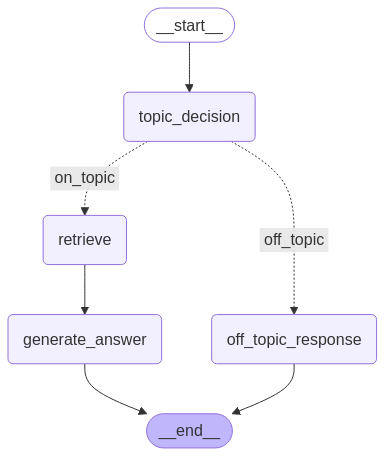

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [10]:
graph.invoke(input={"messages": [HumanMessage(content="When does the Bella Vista restaurant open?")]})

{'messages': [HumanMessage(content='When does the Bella Vista restaurant open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Bella Vista restaurant opens from Monday to Sunday, with weekday hours from 11:00 AM to 10:00 PM and extended weekend hours from 11:00 AM to 11:00 PM.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 305, 'total_tokens': 347, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-f56fbc73-a04b-467c-a335-0a68450340bb-0', usage_metadata={'input_tokens': 305, 'output_tokens': 42, 'total_tokens': 347, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

In [11]:
graph.invoke(input={"messages": [HumanMessage(content="What is artificial intelligence?")]})

{'messages': [HumanMessage(content='What is artificial intelligence?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

## Retrieval with Tools

Invece di usare direttamente il retriever possiamo fare uso del tool calling.

LangChain fornisce la funzione "create_retriever_tool()" che rende il retriever un tool.

Quindi possiamo utilizzare il tool calling come abbiamo fatto nella sezione precedente.

Come primo argomento della funzione "create_retriever_tool()" passiamo il nostro retriever, poi passimao il nome che vogliamo dare al retriever tool.

Inoltre dobbiamo fornire una descrizione per l'LLM in modo che comprenda se deve utilizzare il tool o meno.

In [12]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever, 
    "retriever_tool",
    "Information related to Pricing, Opening hours of the owner of the restaurant Bella Vista"
)

# gestiamo anche la off topic response in un tool
@tool
def off_topic():
    """Catch all Questions NOT related to Pricing, Opening hours of the owner of the restaurant Bella Vista"""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [15]:
# definiamo lo stato del grafo
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [21]:
# creiamo un agent_node
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

def agent(state: AgentState):
    messages = state['messages']
    model = ChatOpenAI(model="gpt-4o")
    model = model.bind_tools(tools) # modello con i tools
    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state: AgentState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls: # è un AIMessage co tool_calls
        return "tools"
    return END

In [22]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)

workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent", 
    should_continue
)

workflow.add_edge("tools", "agent")

graph = workflow.compile()

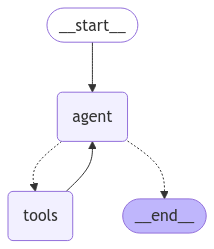

In [23]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [24]:
# off_topic 
graph.invoke(input={"messages": [HumanMessage(content="How will the weather be tomorrow?")]})

{'messages': [HumanMessage(content='How will the weather be tomorrow?', additional_kwargs={}, response_metadata={}, id='41f7e3a3-39ed-4f38-93f1-1a1e49f92f1e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_htVwd8xu6HIgqbpGL2dpIlsW', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 97, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-527dbd4b-6f99-494b-ab5b-3816ecab6ab4-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'call_htVwd8xu6HIgqbpGL2dpIlsW', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 'output_tokens': 11, 't

In [25]:
# on topic 
graph.invoke(input={"messages": [HumanMessage(content="When does the bella vista restaurant open?")]})

{'messages': [HumanMessage(content='When does the bella vista restaurant open?', additional_kwargs={}, response_metadata={}, id='f41236ef-2450-442b-bc9d-b57855dfabb4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_81F5WZ987TLaMvXOyjeGPavq', 'function': {'arguments': '{"query":"Bella Vista restaurant opening hours"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 98, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ebd6a338-716b-4875-9513-d09b88174114-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'Bella Vista restaurant opening hours'}, 'id': 'ca